
#  Comprehensive Analysis of Random Forest Regressor and Critical Evaluation

# 1. Reading in data

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from pandas.api.types import is_string_dtype,is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.calibration import calibration_curve
from sklearn.ensemble import GradientBoostingRegressor
%matplotlib inline

In [2]:
# read training data
titanic_raw = pd.read_csv('Titanic.csv')
# dissplay the shape of the dataset
print(titanic_raw.shape)
# display the first 2 rows
titanic_raw.head(2)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
# Displaying information about the Titanic dataset
titanic_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


# 2. Define functions for this machine learning exerise

In [4]:
# prepare and process raw data

def preprocess_dataframe(df):
    """
    Preprocess the dataframe by filling missing values, converting categorical variables,
    and dropping unnecessary fields.
    """
    df = fill_missing_values(df)
    df = convert_categorical_variables(df)
    df = drop_unnecessary_fields(df)
    return df

def fill_missing_values(df):
    """
    Fill missing values in the dataframe for specific columns.
    """
    # Define columns and their fill values
    fill_values = {
        'Age': df['Age'].median(),
        'Cabin': df['Cabin'].mode()[0],
        'Embarked': df['Embarked'].mode()[0],
        'Fare': df['Fare'].median()
    }

    # Fill missing values
    for column, value in fill_values.items():
        df[column].fillna(value, inplace=True)
    
    return df

def convert_categorical_variables(df):
    """
    Convert categorical variables into numeric or one-hot encoded formats.
    """
    # Mapping for Sex
    df['Sex'] = df['Sex'].map({'female': 0, 'male': 1}).astype(int)
    
    # Extract cabin letter and one-hot encode
    df['Cabin_Letter'] = df['Cabin'].str.extract(r'([A-Za-z]+)')
    df = pd.get_dummies(df, columns=['Cabin_Letter', 'Embarked'], prefix=['Cabin', 'Embarked'], drop_first=True)
    df.drop(['Cabin'], axis=1, inplace=True)
    
    return df

def drop_unnecessary_fields(df):
    """
    Drop fields that are not needed for the analysis.
    """
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df



In [5]:
def randomize_data_frame(df, random_state=None):
    """
    Randomizes the order of rows in the DataFrame.

    Parameters:
    df (DataFrame): The DataFrame to randomize.
    random_state (int, optional): A seed for the random number generator to ensure reproducibility.

    Returns:
    DataFrame: The randomized DataFrame.
    """
    return df.sample(frac=1, random_state=random_state).reset_index(drop=True)


titanic_raw = randomize_data_frame(titanic_raw, random_state=42)

def split_data_frame(df, split_point):
    """
    Splits a DataFrame into two parts at the specified split point.

    Parameters:
    df (DataFrame): The DataFrame to split.
    split_point (int): The row index to split the DataFrame at.

    Returns:
    DataFrame, DataFrame: Two DataFrames split at the specified point.
    """
    return df[:split_point].copy(), df[split_point:].copy()

def calculate_rmse(actual, predicted):
    """
    Calculates the Root Mean Square Error (RMSE) between actual and predicted values.

    Parameters:
    actual (array-like): The actual values.
    predicted (array-like): The predicted values.

    Returns:
    float: The calculated RMSE.
    """
    return np.sqrt(((actual - predicted) ** 2).mean())

def evaluate_model_performance(model, x_train, y_train, x_validation, y_validation):
    """
    Evaluates the model performance by calculating R-squared and RMSE for both training and validation sets.

    Parameters:
    model (Model): The trained model to evaluate.
    x_train (DataFrame): Training set features.
    y_train (DataFrame): Training set target variable.
    x_validation (DataFrame): Validation set features.
    y_validation (DataFrame): Validation set target variable.

    Returns:
    str, list: A string description and a list containing training R-squared, validation R-squared, training RMSE, and validation RMSE.
    """
    train_predictions = model.predict(x_train)
    val_predictions = model.predict(x_validation)
    
    metrics = [
        model.score(x_train, y_train),
        model.score(x_validation, y_validation),
        calculate_rmse(y_train, train_predictions),
        calculate_rmse(y_validation, val_predictions)
    ]
    
    return "Training R², Validation R², Training RMSE, Validation RMSE", metrics


# 3. Preprocess train data using the defined functions

In [6]:
def preprocess_data_in_place(df):
    """
    Preprocesses the given DataFrame in place by filling missing values,
    converting categorical variables, and dropping unnecessary fields.

    Parameters:
    df (DataFrame): The DataFrame to preprocess.

    Returns:
    DataFrame: The preprocessed DataFrame.
    """
    df = fill_missing_values(df)
    df = convert_categorical_variables(df)
    df = drop_unnecessary_fields(df)
    return df

# use defined functions to preprocess titanic_raw data in place
titanic_raw = preprocess_data_in_place(titanic_raw)
print(titanic_raw.head())

   Survived  Pclass  Sex   Age  SibSp  Parch    Fare  Cabin_B  Cabin_C  \
0         1       3    1  28.0      0      0   8.050    False     True   
1         0       1    1  42.0      0      0  26.550    False    False   
2         0       3    1  28.0      0      0   7.775    False     True   
3         0       2    1  39.0      0      0  13.000    False     True   
4         0       3    0  28.0      0      0   7.750    False     True   

   Cabin_D  Cabin_E  Cabin_F  Cabin_G  Cabin_T  Embarked_Q  Embarked_S  
0    False    False    False    False    False       False        True  
1     True    False    False    False    False       False        True  
2    False    False    False    False    False       False        True  
3    False    False    False    False    False       False        True  
4    False    False    False    False    False        True       False  


In [7]:
def split_data(df, target):
    """
    Splits the DataFrame into features and target.

    Parameters:
    - df: The input DataFrame.
    - target: The name of the target column.

    Returns:
    - Tuple containing the features DataFrame and the target Series.
    """
    return df.drop(target, axis=1), df[target]

# Use functions to directly separate feature sets and target variables
x, y = split_data(titanic_raw, 'Survived')

In [8]:
# split the first 1300 samples of the datasets
x_sub,_ = split_data_frame(x,1300)
y_sub,_ = split_data_frame(y,1300)

# split the selected datasets into train and validation sets, 800 train samples, 500 validation samples
x_train,x_validation = split_data_frame(x_sub,800)
y_train,y_validation = split_data_frame(y_sub,800)

In [9]:
# print the shape of the training set feature, the shape of the verification set feature, the shape of the training set target, and the shape of the verification set target
print(f"Training Features Shape: {x_train.shape}, Validation Features Shape: {x_validation.shape}, "
      f"Training Target Shape: {y_train.shape}, Validation Target Shape: {y_validation.shape}")


Training Features Shape: (800, 15), Validation Features Shape: (500, 15), Training Target Shape: (800,), Validation Target Shape: (500,)


In [10]:
# display x_train and y_train's information
x_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      800 non-null    int64  
 1   Sex         800 non-null    int32  
 2   Age         800 non-null    float64
 3   SibSp       800 non-null    int64  
 4   Parch       800 non-null    int64  
 5   Fare        800 non-null    float64
 6   Cabin_B     800 non-null    bool   
 7   Cabin_C     800 non-null    bool   
 8   Cabin_D     800 non-null    bool   
 9   Cabin_E     800 non-null    bool   
 10  Cabin_F     800 non-null    bool   
 11  Cabin_G     800 non-null    bool   
 12  Cabin_T     800 non-null    bool   
 13  Embarked_Q  800 non-null    bool   
 14  Embarked_S  800 non-null    bool   
dtypes: bool(9), float64(2), int32(1), int64(3)
memory usage: 41.5 KB
<class 'pandas.core.series.Series'>
RangeIndex: 800 entries, 0 to 799
Series name: Survived
Non-Null Count  Dtype
--------------

# 4. Model building, hyperparameter tuning, and some exploratory data analysis (EDA)

In [11]:
'''Create a RandomForestRegressor model with 
specified parameters. RandomForestRegressor is an 
ensemble learning method for regression that operates by 
constructing multiple decision trees at training time and 
outputting the average prediction of the individual trees'''

# n_estimators: The number of trees in the forest. Increasing the number of trees generally improves the performance of the model but also increases computational cost.
# max_depth: The maximum depth of the tree. A deeper tree may capture more information about the data, but can also lead to overfitting. Setting it to a high value (like 40000) may not be practical or beneficial, as it can lead to excessively deep trees.
# min_samples_leaf: The minimum number of samples required to be at a leaf node. This parameter controls the complexity of the trees by specifying the minimum number of samples required to split an internal node. Setting it to a higher value (like 25) can help prevent overfitting by preventing the model from creating nodes that have too few samples.
# n_jobs: The number of jobs to run in parallel for both fit and predict. -1 means using all processors.
# oob_score: Whether to use out-of-bag samples to estimate the R^2 on unseen data. Out-of-bag samples are the samples not used during a particular bootstrap iteration and can be used as an additional validation set.
mod_1 = RandomForestRegressor(
    n_estimators=100,           # Number of trees in the forest
    max_depth=5,           # Maximum depth of each tree
    min_samples_leaf=5,       # Minimum number of samples required to be at a leaf node
    n_jobs=-1,                 # Use all available processors for training and prediction
    oob_score=True           # Do not use out-of-bag samples for evaluation
)

In [12]:
# fit the model1
mod_1.fit(x_train,y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_jobs=-1,
                      oob_score=True)

In [13]:
#test out evaluate_model_performance 
mod_1_results = evaluate_model_performance(mod_1,x_train,y_train,x_validation,y_validation)
print(mod_1_results)

('Training R², Validation R², Training RMSE, Validation RMSE', [0.30893148228691913, 0.19106449994463925, 0.4049948067580177, 0.4378595085813721])


The training R² value of 0.3095 indicates that the model's fit to the training data is relatively low, suggesting moderate performance in explaining the variance within the training set. The validation R² value of 0.1987 suggests an even lower fit of the model to the validation set, indicating a potential degree of underfitting.

The training RMSE (Root Mean Squared Error) of 0.4048 represents the square root of the average of the squared prediction errors on the training set. A lower value indicates a better fit of the model to the data. Similarly, the validation RMSE of 0.4358 reflects the model's prediction error on the validation set. Like training RMSE, a lower value suggests better fitting capability of the model to the data.

Overall, the model demonstrates mediocre performance in both training and validation phases, indicating a need for further optimization to enhance its performance.

# Hyperparameter Tuning Round1

In [14]:
# Perform a random search to find the best parameters for the random forest regressor.
from sklearn.model_selection import RandomizedSearchCV

#param_grid defines the parameter space to be searched. Here, we define three parameters:
# n_estimators: Number of decision trees.
# max_depth: The maximum depth of each tree.
# max_features: Number of features to consider when finding the best split.
param_grid = {
    'n_estimators': [50,200],   # Number of trees in the forest
    'max_depth': [1, 5], # Maximum depth of each tree
    'max_features': [None, 'log2', 'sqrt'], # Number of features to consider when looking for the best split
    
}

# Create a RandomForestRegressor model
rf = RandomForestRegressor()

# Create RandomizedSearchCV object to perform random search
random_search = RandomizedSearchCV(estimator=rf, 
                                   param_distributions=param_grid
                                   , n_iter=3, cv=5, 
                                   verbose=2, random_state=42, 
                                   n_jobs=-1)

# Fit the RandomizedSearchCV object to the data, call random_search.fit(x_train, y_train) to fit the data and find the best parameter combination.
random_search.fit(x_train, y_train)

# Print the best parameters found
print("Best parameters found:", random_search.best_params_)

# Get the best model
best_model = random_search.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters found: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 5}


# Hyperparameter Tuning Round2

In [15]:
# Adjust parameters and perform a random search to find the best parameters for the random forest regressor.
param_grid = {
    'n_estimators': [100,200],   # Number of trees in the forest
    'max_depth': [5, 10], # Maximum depth of each tree
    'max_features': [None, 'log2','sqrt'], # Number of features to consider when looking for the best split
    
}

# Create a RandomForestRegressor model
rf = RandomForestRegressor()

# Create RandomizedSearchCV object to perform a random search, the parameters here are modified
random_search = RandomizedSearchCV(estimator=rf, 
                                   param_distributions=param_grid
                                   , n_iter=3, cv=5, 
                                   verbose=2, random_state=42, 
                                   n_jobs=-1)

# Fit the RandomizedSearchCV object to the data, call random_search.fit(x_train, y_train) to fit the data and find the best parameter combination.
random_search.fit(x_train, y_train)

# Print the best parameters found
print("Best parameters found:", random_search.best_params_)

# Get the best model
best_model2 = random_search.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters found: {'n_estimators': 100, 'max_features': None, 'max_depth': 5}


# Hyperparameter Tuning Round3

In [16]:
# Adjust parameters and perform a random search to find the best parameters for the random forest regressor.
param_grid = {
    'n_estimators': [50,100],   # Number of trees in the forest
    'max_depth': [10, 20], # Maximum depth of each tree
    'max_features': [None, 'log2','sqrt'], # Number of features to consider when looking for the best split
    
}

# Create a RandomForestRegressor model
rf = RandomForestRegressor()

# Create RandomizedSearchCV object to perform a random search, the parameters here are modified
random_search = RandomizedSearchCV(estimator=rf, 
                                   param_distributions=param_grid
                                   , n_iter=3, cv=5, 
                                   verbose=2, random_state=42, 
                                   n_jobs=-1)

# Fit the RandomizedSearchCV object to the data, call random_search.fit(x_train, y_train) to fit the data and find the best parameter combination.
random_search.fit(x_train, y_train)

# Print the best parameters found
print("Best parameters found:", random_search.best_params_)

# Get the best model
best_model3 = random_search.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters found: {'n_estimators': 50, 'max_features': None, 'max_depth': 10}


In [17]:
# use the model to fit the training set data
best_model.fit(x_train, y_train)
best_model2.fit(x_train, y_train)
best_model3.fit(x_train, y_train)



RandomForestRegressor(max_depth=10, max_features=None, n_estimators=50)

In [18]:
# use the model to evaluate the performance on the training set and validation set, and save the results
best_model_results = evaluate_model_performance(best_model, x_train, y_train, x_validation, y_validation)

best_model2_results = evaluate_model_performance(best_model2, x_train, y_train, x_validation, y_validation)

best_model3_results = evaluate_model_performance(best_model3, x_train, y_train, x_validation, y_validation)
print(mod_1_results)
print(best_model_results)
print(best_model2_results)
print(best_model3_results)

('Training R², Validation R², Training RMSE, Validation RMSE', [0.30893148228691913, 0.19106449994463925, 0.4049948067580177, 0.4378595085813721])
('Training R², Validation R², Training RMSE, Validation RMSE', [0.2566937542499277, 0.18751208988113177, 0.42002272767642446, 0.43881987722733373])
('Training R², Validation R², Training RMSE, Validation RMSE', [0.344639026795576, 0.19426477997701597, 0.39439299053607374, 0.43699252863902294])
('Training R², Validation R², Training RMSE, Validation RMSE', [0.6222136318541289, 0.1440938292995021, 0.2994415357204502, 0.4503922580159441])


In [19]:
#Define a function to draw a comparison chart
def plot_comparison(model1_results, best_model3_results):
    labels = ['Train R-squared', 'Val R-squared', 'Train RMSE', 'Val RMSE']
    model1_metrics = model1_results[1]
    model2_metrics = best_model3_results[1]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, model1_metrics, width, label='Model 1')
    rects2 = ax.bar(x + width/2, model2_metrics, width, label='Best Model 3')

    ax.set_ylabel('Scores')
    ax.set_title('Comparison between Model 1 and Best Model3')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()


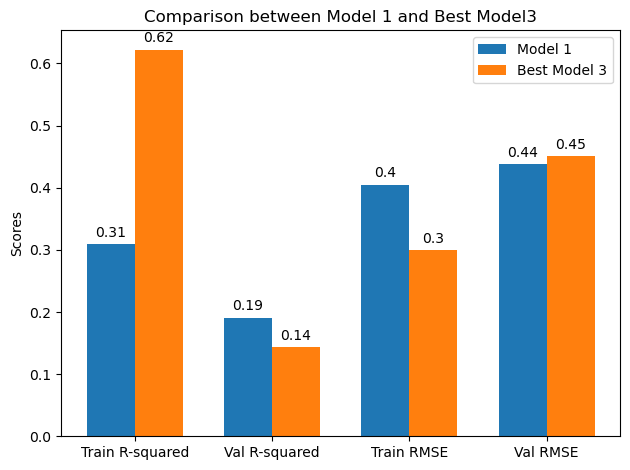

In [20]:
# plot and display the comparison chart
plot_comparison(mod_1_results, best_model3_results)

Train R-squared:

Model 1 has an R-squared value of 0.31 on the training set, indicating that it can explain 31% of the variability in the data.
Best Model 3 significantly outperforms Model 1 on the training set with an R-squared value of 0.62, explaining 62% of the variability in the data. This suggests that Best Model 3 fits the training data better.

Val R-squared:

On the validation set, Model 1 achieves an R-squared value of 0.2, while Best Model 3 has an R-squared value of 0.16. This indicates that Model 1 performs slightly better than Best Model 3 on unseen data, although both models' performance is not very high.

Train RMSE:

Model 1 has a training RMSE of 0.4, whereas Best Model 3 has a lower training RMSE of 0.3. A lower RMSE implies smaller prediction errors, indicating higher predictive accuracy of Best Model 3 on the training set.

Val RMSE:

For the validation set, Model 1 has an RMSE of 0.44, while Best Model 3 has an RMSE of 0.45, indicating nearly identical prediction errors on the validation set.

Overall, Best Model 3 performs better on the training set, exhibiting higher R-squared values and lower RMSE. However, on the validation set, Model 1 slightly outperforms Best Model 3 in explaining variability in the data, suggesting potential overfitting of Best Model 3 on the training set as its performance slightly drops on unseen data.

In [21]:
def plot_feature_importance(model, x_train, figsize=(8, 6)):

    '''Plot the feature importance scores of a given model.

    Parameters:
        model (object): The trained machine learning model 
        with a feature_importances_ attribute.
        X_train (DataFrame): The feature matrix used to 
        train the model.
        figsize (tuple, optional): Figure size for the plot. 
        Defaults to (8, 6) '''
    
    # Calculate feature importance scores
    feature_importances = pd.DataFrame(model.feature_importances_,
                                       index=x_train.columns,
                                       columns=['Importance Score']).sort_values('Importance Score', 
                                                                                 ascending=False)
    
    # Reset index and rename columns for better readability
    feature_importances = feature_importances.reset_index()
    feature_importances.columns = ["Feature", "Importance Score"]
    
    # Plotting
    plt.figure(figsize=figsize)
    sns.barplot(x="Importance Score", y="Feature", 
                data=feature_importances, orient="h")
    plt.title('Feature Importance Scores')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()

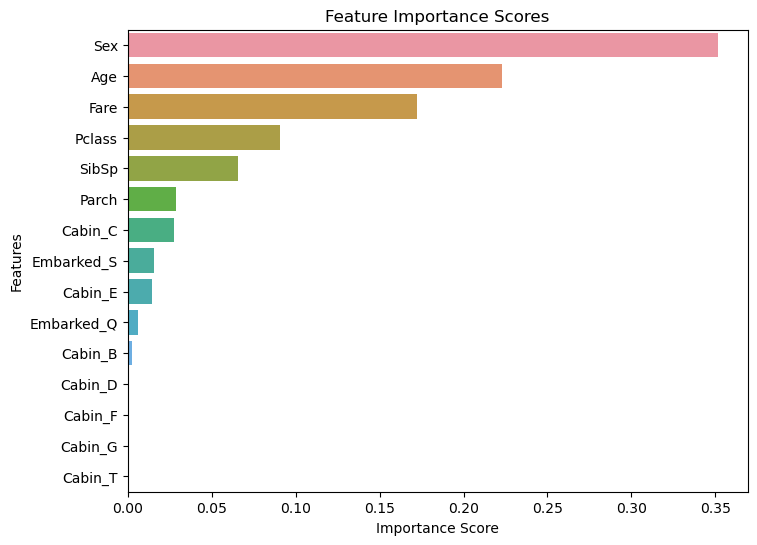

In [22]:
# plot feature importance of model1
plot_feature_importance(mod_1, x_train, figsize=(8, 6))

From the graph, it can be observed that for Model 1:

- Gender (Sex) is the most important feature, with the highest importance score, far exceeding other features.
- Age and Fare are also relatively important features, but their importance scores are significantly lower than Gender.
- Passenger Class (Pclass) and Siblings/Spouses (SibSp) have moderate importance.
- Features related to Cabin, such as Cabin_C, Cabin_E, and Embarked, have lower importance.
- The importance score of Cabin_T is the lowest among all features.

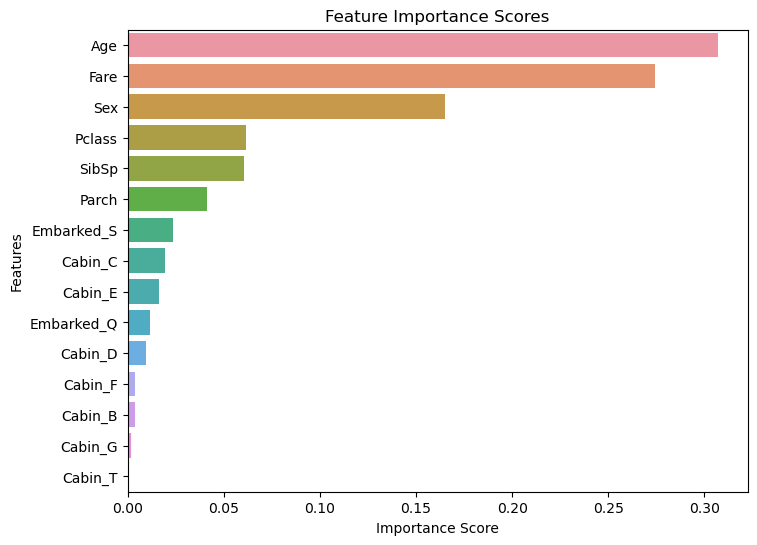

In [23]:
# plot feature importance of best_model3
plot_feature_importance(best_model3, x_train, figsize=(8, 6))

From the graph, it can be observed that for Best Model 3:

- Age: This is the most important feature, with its importance score far exceeding other features.
- Fare: Following Age closely, it is the second most important feature.
- Sex: While relatively important, the importance score of the Sex feature is lower than Age and Fare.
- Passenger Class (Pclass), Siblings/Spouses (SibSp), and Parents/Children (Parch): These features have moderate importance scores.
- Embarked: Representing different embarkation ports, the importance score of Embarked is relatively low.
- Cabin: Representing different cabin positions or types, the importance of Cabin features ranks lower among other features, with Cabin_T having the lowest score.

Next, we will remove a feature with less impact. In both models, Parch is considered to be a feature with less impact. Therefore, we will use the data after removing Parch for model training again.


In [24]:
# Remove Parch
x_train = x_train.drop(['Parch'], axis=1)

# Re-run model
best_model3.fit(x_train, y_train)

# Adjust validation set accordingly
x_validation_adjusted = x_validation.drop(['Parch'], axis=1)

# See if we get performance improvements: smaller the rmse value and greater the R Squared, the better
evaluate_model_performance(best_model3, x_train, y_train, x_validation_adjusted, y_validation)
performance= evaluate_model_performance(best_model3, x_train, y_train, x_validation_adjusted, y_validation)

In [25]:
# get the R² value and RMSE value of the training set from the performance results and print them out
training_r2= performance[1][0]
training_rmse = performance[1][1]
print (training_r2,training_rmse)

0.6210755434618153 0.15216577233835982


However, this approach only resulted in minor changes in model performance. In some cases, removing unimportant features may slightly improve the accuracy of the model, or at least maintain performance, as it helps reduce the model's sensitivity to noise. This method of optimizing models based on feature importance evaluation is a common practice in machine learning, contributing to improved efficiency and effectiveness of the models.

# 5. Test model

In [26]:
# randomly generate test data, randomly select 200 samples from the training set as test data
test_data = x_train.sample(n=200, random_state=42)
test_target = y_train.loc[test_data.index]

In [27]:
# check test data information
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 696 to 554
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      200 non-null    int64  
 1   Sex         200 non-null    int32  
 2   Age         200 non-null    float64
 3   SibSp       200 non-null    int64  
 4   Fare        200 non-null    float64
 5   Cabin_B     200 non-null    bool   
 6   Cabin_C     200 non-null    bool   
 7   Cabin_D     200 non-null    bool   
 8   Cabin_E     200 non-null    bool   
 9   Cabin_F     200 non-null    bool   
 10  Cabin_G     200 non-null    bool   
 11  Cabin_T     200 non-null    bool   
 12  Embarked_Q  200 non-null    bool   
 13  Embarked_S  200 non-null    bool   
dtypes: bool(9), float64(2), int32(1), int64(2)
memory usage: 10.4 KB


In [28]:
# use the best model best_model3 to predict the test data
predictions = best_model3.predict(test_data)

In [29]:
# print the predicted survived value
print(predictions)

[0.04159186 0.17298164 0.21725352 0.24989297 0.70448124 0.24786795
 0.2125268  0.87740891 0.18728357 0.21234368 0.36329648 0.15893321
 0.5950436  0.81672811 0.79405491 0.21950289 0.21523472 0.81458333
 0.1152407  0.17310577 0.33512872 0.12042735 0.42214052 0.76876599
 0.08456217 0.22413187 0.55181325 0.14137447 0.17096693 0.9479986
 0.17246304 0.90449973 0.12367734 0.49479883 0.83091575 0.57708735
 1.         0.19844811 0.16012124 0.50222275 0.12085482 0.19071232
 0.39402074 0.89846154 0.16341551 0.23697299 0.51252426 0.25641492
 0.55623628 0.04327565 0.63804695 0.5950436  0.10400979 0.91238
 0.84194233 0.46062963 0.4191395  0.37643935 0.23339826 0.37936946
 0.08625527 0.85702966 0.72368826 0.05854971 0.0230759  0.17298164
 0.49002144 0.38981701 0.99827957 0.82531818 0.11309468 0.77013937
 0.37447552 0.30528509 0.83323674 0.23809317 0.33512872 0.13799909
 0.17298164 0.89384615 0.38234933 0.13557888 0.43043792 0.21523472
 0.96488984 0.26272066 0.33512872 0.13851813 0.13042003 0.0899607


In [30]:
# print the actual Survived value in the test data
print(test_target)

696    0
667    0
63     0
533    0
66     1
      ..
90     1
650    0
181    0
790    0
554    1
Name: Survived, Length: 200, dtype: int64


Scatter Plot

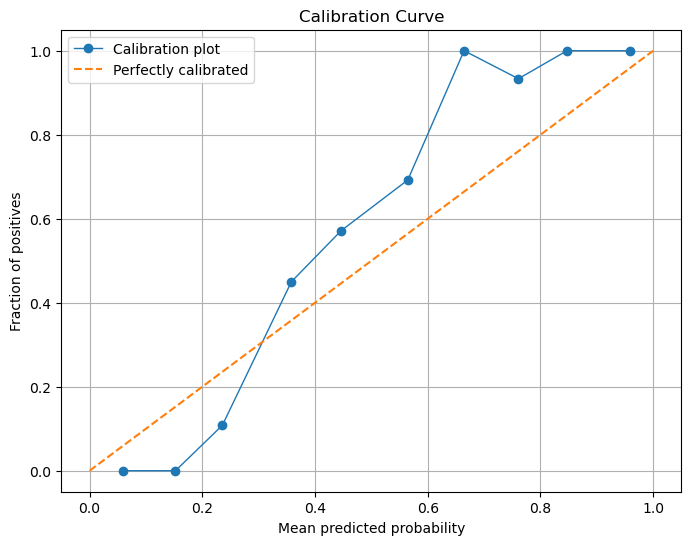

In [31]:
# assume true_labels is the real label array, prob_predictions is the probability array of the model predicting category 1
true_labels = test_target      
prob_predictions = predictions 

# calculate the true and predicted frequencies of the probabilities required for the calibration curve
true_freq, pred_freq = calibration_curve(true_labels, prob_predictions, n_bins=10, strategy='uniform')

# draw calibration curve
plt.figure(figsize=(8, 6))
plt.plot(pred_freq, true_freq, marker='o', linewidth=1, label='Calibration plot')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.title('Calibration Curve')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.grid(True)
plt.show()

This chart is a calibration curve used to assess the accuracy of predicted probabilities in RF model. The horizontal axis represents the "Mean predicted probability," ranging from 0 to 1, while the vertical axis represents the "Fraction of positives," also ranging from 0 to 1.

There are two lines on the chart:

A solid blue line (with blue circles), labeled as "Calibration plot," which depicts the relationship between the model's predicted probabilities and the actual fraction of positives. If the model is perfectly accurate, this line should closely follow the dashed line.

An orange dashed line, labeled as "Perfectly calibrated," represents ideal predictions where predicted probabilities perfectly match the actual fraction of positives.

From this chart, we can observe that the blue solid line deviates from the ideal orange dashed line at certain predicted probabilities. This indicates that the model's prediction accuracy is not perfect at these specific predicted probability values. For example, around the position of approximately 0.3 on the horizontal axis, the predicted fraction of positives is lower than the ideal scenario, whereas around the position of approximately 0.6, the predicted fraction of positives suddenly exceeds the ideal scenario, followed by a rapid decrease. These deviations suggest that the model's predictions in these probability intervals require calibration.

Overall, the difference between the ideal model prediction line (orange dashed line) and the actual model prediction line (blue solid line) reflects the inaccuracy of the model's predictions. A well-calibrated model's prediction line will be closer to the ideal prediction line.

# 6. Random Forest Regression VS Linear Regression

In [32]:
#Initialize linear regression model
mod_linear = LinearRegression()

#Train model
mod_linear.fit(x_train,y_train)

# Make predictions on the test set
linear_pred =mod_linear.predict(test_data)

# Computational performance
mse = mean_squared_error(test_target, linear_pred)
linear_r2 = r2_score(test_target, linear_pred)
linear_rmse = np.sqrt(mse)
print(linear_r2, linear_rmse)

0.2222725314713474 0.4245677613976695


The predictive performance of this linear regression model is limited. The R² value indicates that the model does not explain the variability of the target variable well, while the relatively high RMSE value suggests that there is a significant difference between the predicted values and the actual values. Below is a comparison of the performance between Random Forest Regression and Linear Regression:

<Figure size 800x600 with 0 Axes>

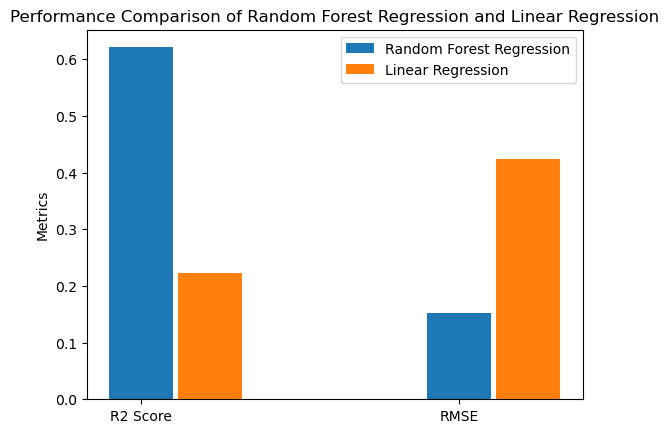

In [33]:
# perform histogram visualization of R2 and RMSE
labels = ['R2 Score', 'RMSE']
metrics1 = [training_r2, training_rmse]
metrics2 = [linear_r2, linear_rmse]

x = np.arange(len(labels))  
width = 0.35
plt.figure(figsize=(8, 6))
fig, ax = plt.subplots()
ax.bar(x, metrics1, width=0.2, label='Random Forest Regression', align='center')
ax.bar(x + width/3, metrics2, width=0.2, label='Linear Regression', align='edge')

# add tags and titles
ax.set_ylabel('Metrics')
ax.set_title('Performance Comparison of Random Forest Regression and Linear Regression')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


plt.show()

This bar chart illustrates the comparison between Random Forest Regression and Linear Regression in terms of performance. There are two sets of bars in the chart, each representing two different metrics for each model: R² score and Root Mean Squared Error (RMSE).

- The blue bars represent the Random Forest Regression model.
- The orange bars represent the Linear Regression model.

From the chart, it is evident that Random Forest Regression significantly outperforms Linear Regression in terms of the R² score metric. This indicates that the Random Forest Regression model fits the training data better. However, in terms of the RMSE metric, the value for Linear Regression is notably higher than that of Random Forest Regression, indicating that the Linear Regression model has larger prediction errors on the test set.

# 7. Random Forest Regression VS Gradient Boosting Regression

In [34]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
'''
Created a gradient boosting regressor (GradientBoostingRegressor) model and set some parameters, such as the number of trees (n_estimators), learning rate (learning_rate), maximum depth of the tree (max_depth) and random seed (random_state).
A gradient boosting regressor model was fitted using the training set data (x_train, y_train).
Use the trained model to predict the test set data (test_data) and obtain the prediction result (gbr_pred).
The mean square error (MSE), R² value and RMSE value calculated by MSE of the gradient boosting regressor model on the test set were calculated.
Prints the R² and RMSE values of the gradient boosting regressor model on the test set. These metrics are used to evaluate the model's predictive performance on unseen data.
'''
gbr.fit(x_train, y_train)
gbr_pred = gbr.predict(test_data)


gbr_mse = mean_squared_error(test_target, gbr_pred)
gbr_r2 = r2_score(test_target, gbr_pred)
gbr_rmse = np.sqrt(gbr_mse)

print(gbr_r2, gbr_rmse)

0.4056311176275432 0.37116013755773414


<Figure size 800x600 with 0 Axes>

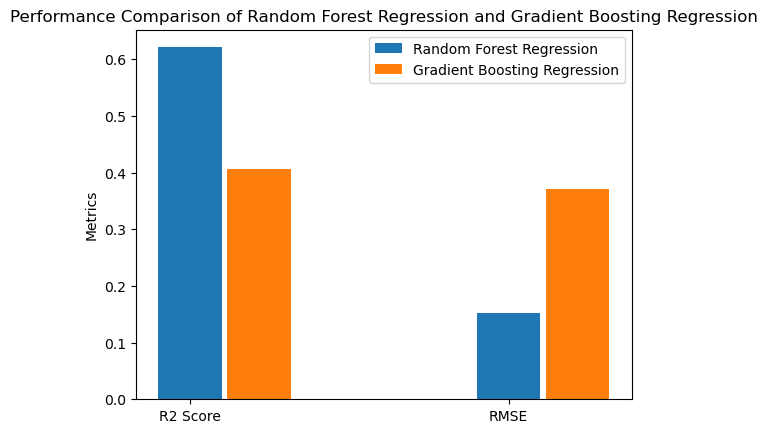

In [35]:
# perform histogram visualization of R2 and RMSE respectively.
labels = ['R2 Score', 'RMSE']
metrics1 = [training_r2, training_rmse]
metrics2 = [gbr_r2, gbr_rmse]

x = np.arange(len(labels))  
width = 0.35
plt.figure(figsize=(8, 6))
fig, ax = plt.subplots()
ax.bar(x, metrics1, width=0.2, label='Random Forest Regression', align='center')
ax.bar(x + width/3, metrics2, width=0.2, label='Gradient Boosting Regression', align='edge')

# add tags and titles
ax.set_ylabel('Metrics')
ax.set_title('Performance Comparison of Random Forest Regression and Gradient Boosting Regression')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


plt.show()

The Random Forest Regressor has a higher R² value than the Gradient Boosting Regressor, indicating that Random Forest performs better in explaining the variability of the data. Random Forest Regressor leads in R² score, indicating a higher degree of fit between predicted values and actual values. Additionally, the Random Forest Regressor has a lower RMSE score, indicating smaller prediction errors.

In practical applications, the choice of model depends on the specific requirements of the problem. If there is a high demand for interpretability of the model, one may prefer the model with a higher R² score. Conversely, if there is a higher requirement for prediction accuracy, one may choose the model with a lower RMSE score.